# **NLP PROJECT : PRODUCTS REVIEW CLASSIFICATION**

**Name : Zain ul abideen**

**SapId: 70158131**

**Subject : NLP**

<h1 style="color:red">Task # 3 - Preprocessing</h1>

## Objective
In this notebook, we perform **text preprocessing and data augmentation** on Amazon Product Reviews to prepare data for sentiment classification.

---

## Steps
1. [Import Libraries](#import)
2. [Load Dataset](#load)
3. [Initial Exploration](#explore)
4. [Word Spacing Correction]
5. [Data Cleaning & Preprocessing](#preprocess)
   - Removing HTML tags  
   - Removing punctuation & special characters  
   - Stopword removal  
   - Lemmatization  
   - Text normalization  
   - Whitespace removal  
   - Handling OOV words  
   - Removing duplicates  
   - Handling missing values  
6. [Data Augmentation](#augment)
7. [Vectorization](#vector)
8. [Export Cleaned Dataset](#export)


In [1]:
# 🔹 Importing libraries
import pandas as pd
import numpy as np
import re
import nltk
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import TfidfVectorizer
import random
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize



# Download required NLTK data
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

print("✅ Libraries imported successfully!")


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...


✅ Libraries imported successfully!


## Step 1: Load Dataset <a id="load"></a>

We will load our Amazon Product Reviews dataset, inspect the first few records, and identify useful columns for text analysis.


In [2]:
# Load dataset
df = pd.read_csv("/kaggle/input/Amazon-Product-Reviews - Amazon Product Review (1).csv")

# Show basic info
df.info()
df.head()

# --- Keep only important columns ---
df = df[['review_body', 'sentiment', 'star_rating', 'helpful_votes']]


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30846 entries, 0 to 30845
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   marketplace        30846 non-null  object
 1   customer_id        30846 non-null  int64 
 2   review_id          30846 non-null  object
 3   product_id         30846 non-null  object
 4   product_parent     30846 non-null  int64 
 5   product_title      30846 non-null  object
 6   product_category   30846 non-null  object
 7   star_rating        30846 non-null  int64 
 8   helpful_votes      30846 non-null  int64 
 9   total_votes        30846 non-null  int64 
 10  vine               30846 non-null  object
 11  verified_purchase  30846 non-null  object
 12  review_headline    30844 non-null  object
 13  review_body        30842 non-null  object
 14  review_date        30846 non-null  object
 15  sentiment          30846 non-null  int64 
dtypes: int64(6), object(10)
memory usage: 3.

## Step 2: Initial Exploration <a id="explore"></a>

Let's check for missing values, duplicates, and distribution of sentiment classes to understand our dataset better.


In [3]:
# Check missing values
print(df.isnull().sum())

# Check duplicates
print("Duplicates:", df.duplicated().sum())

# Class distribution
print("\nSentiment Class Distribution:")
print(df['sentiment'].value_counts())

review_body      4
sentiment        0
star_rating      0
helpful_votes    0
dtype: int64
Duplicates: 2813

Sentiment Class Distribution:
sentiment
1    25767
0     5079
Name: count, dtype: int64


## Step 3: Data Cleaning & Preprocessing <a id="preprocess"></a>

We’ll perform:
- HTML tag removal  
- Special character and punctuation removal  
- Stopword removal  
- Lemmatization  
- Text normalization (lowercasing)  
- Whitespace trimming  
- Handling missing and duplicate records


In [4]:
# Initialize tools
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    if pd.isnull(text):
        return ""
    text = BeautifulSoup(text, "html.parser").get_text()                # Remove HTML tags
    text = re.sub(r"[^a-zA-Z\s]", "", text)                             # Remove punctuation/special chars
    text = text.lower()                                                 # Lowercase
    words = text.split()
    words = [w for w in words if w not in stop_words]                   # Remove stopwords
    words = [lemmatizer.lemmatize(w) for w in words]                    # Lemmatization
    return " ".join(words).strip()

# Apply cleaning
df['cleaned_text'] = df['review_body'].apply(clean_text)

# Remove duplicates and missing values
df.drop_duplicates(subset=['cleaned_text'], inplace=True)
df.dropna(subset=['cleaned_text'], inplace=True)

print("✅ Cleaning completed. Total records:", len(df))


✅ Cleaning completed. Total records: 25577


##  Step 4: Word Spacing Correction
In this step, we use the **WordSegment** library to handle run-on words where users accidentally type multiple words together, such as:
> "amazonnetflixhullu" → "amazon netflix hullu"

This ensures our tokenizer and vectorizer can correctly interpret separate words, improving the accuracy of our NLP model later.


In [5]:
# Install library for smart spacing correction
!pip install wordsegment

from wordsegment import load, segment
load()

def smart_spacing(text):
    """
    Corrects words that are joined together without spaces,
    e.g. 'amazonnetflixhullu' -> 'amazon netflix hullu'
    """
    try:
        # Apply segmentation on each token individually
        return " ".join(segment(text))
    except:
        return text  # fallback if segmentation fails

# Apply to cleaned text column
df['cleaned_text'] = df['cleaned_text'].apply(lambda x: " ".join([smart_spacing(w) for w in x.split()]))


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 48.9 MB/s eta 0:00:00a 0:00:01


## Step 5: Handle Missing & OOV Words

We handle null or unknown tokens and remove columns not needed for training.


In [6]:
# Replace empty strings with a placeholder
df['cleaned_text'].replace('', np.nan, inplace=True)
df.dropna(subset=['cleaned_text'], inplace=True)

# Drop unrelated columns
df = df[['cleaned_text', 'sentiment','star_rating', 'helpful_votes']]

print("✅ Nulls handled and irrelevant columns removed.")


✅ Nulls handled and irrelevant columns removed.


/tmp/ipykernel_38/2945593360.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['cleaned_text'].replace('', np.nan, inplace=True)


## Step 6: Data Augmentation & Tokenization <a id="augment"></a>

To make our model more robust, we’ll use **Synonym Replacement** from WordNet to generate slightly modified versions of reviews.


In [7]:
def synonym_replacement(text, n=2):
    words = text.split()
    new_words = words.copy()
    random_word_list = list(set([word for word in words if word.isalpha()]))
    random.shuffle(random_word_list)
    num_replaced = 0

    for random_word in random_word_list:
        synonyms = wordnet.synsets(random_word)
        if not synonyms:
            continue
        synonym_words = set()
        for syn in synonyms:
            for lemma in syn.lemmas():
                synonym_words.add(lemma.name())
        synonym_words.discard(random_word)
        if len(synonym_words) >= 1:
            synonym = random.choice(list(synonym_words))
            new_words = [synonym if word == random_word else word for word in new_words]
            num_replaced += 1
        if num_replaced >= n:
            break
    return ' '.join(new_words)

# Apply augmentation to 10% of dataset
sample_df = df.sample(frac=0.1, random_state=42)
sample_df['cleaned_text'] = sample_df['cleaned_text'].apply(lambda x: synonym_replacement(str(x)))
df_augmented = pd.concat([df, sample_df], ignore_index=True)

print(f"✅ Data augmentation done! New dataset size: {len(df_augmented)}")

# Download tokenizer if not already done
nltk.download('punkt')

# Tokenization function
def tokenize_text(text):
    return word_tokenize(text)

# Apply tokenization to your dataframe
df_augmented['tokens'] = df_augmented['cleaned_text'].apply(tokenize_text)

# Check the first few rows
print(df_augmented[['cleaned_text']].head())


✅ Data augmentation done! New dataset size: 28134


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


                                        cleaned_text
0                                         great love
1  lot ads slow processing speed occasionally shu...
2  excellent unit versatility tablet besides comp...
3  bought amazon prime ended buying gb one camera...
4           amazon product continue meet expectation


## Step 7: Text Vectorization <a id="vector"></a>

We convert text into numerical form using **TF-IDF Vectorization**, which measures how important each word is within the corpus.


In [8]:
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df_augmented['cleaned_text']).toarray()

print("✅ TF-IDF vectorization complete.")
print("Shape of feature matrix:", X.shape)


✅ TF-IDF vectorization complete.
Shape of feature matrix: (28134, 5000)


## Step 8: Export Cleaned & Augmented Dataset <a id="export"></a>

We’ll save the processed dataset as a CSV file for use in model training (CNN, LSTM, or BERT).


In [9]:
df_augmented.to_csv("/kaggle/working/cleaned_augmented_reviews.csv", index=False)
print("📁 Saved cleaned_augmented_reviews.csv successfully!")


📁 Saved cleaned_augmented_reviews.csv successfully!


<h1 style="color:red">Task 4 — Text Representation Techniques</h1>

In this task, we applied three widely used text representation techniques on the preprocessed product reviews dataset.  
These techniques convert text into numerical format so that machine learning models can understand and learn from it.

The three techniques used are:

1. **TF-IDF (Term Frequency – Inverse Document Frequency)**
2. **Bag of Words (CountVectorizer)**
3. **One-Hot Encoding (Binary CountVectorizer)**

Each technique is applied separately, and the output is saved as an Excel file.

## Steps 

We begin by loading the already preprocessed CSV file that contains the cleaned text.  
This includes steps like tokenization, stopword removal, punctuation removal, and normalization.

## Technique 1 — TF-IDF (Term Frequency – Inverse Document Frequency)

TF-IDF is a text representation method that assigns higher weights to rare but important words  
and lower weights to common words.

**Why TF-IDF?**
- Helps highlight meaningful words.
- Reduces the weight of very frequent but less informative words like “good”, “product”, etc.
- Performs better than Bag of Words for many classification tasks.

We use `TfidfVectorizer` to convert text into TF-IDF feature vectors.


## Technique 2 — Bag of Words (CountVectorizer)

Bag of Words (BoW) is one of the simplest text representation methods.  
It counts how many times each word appears in the text.

**Important characteristics:**
- Only considers word frequency.
- Does not care about word order.
- Dimension becomes large as vocabulary grows.

We use `CountVectorizer` to generate frequency-based feature vectors.

## Technique 3 — One-Hot Encoding (Binary CountVectorizer)

One-Hot Encoding represents each word as **1 if the word exists in the text**,  
and **0 if it does not exist**, regardless of frequency.

This is similar to Bag of Words but uses binary values instead of frequencies.

**When is OHE useful?**
- When we only care about presence/absence of words.
- Useful in simple or small datasets.

We use CountVectorizer with the `binary=True` parameter.

In [10]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# Load your preprocessed data
df = pd.read_csv('/kaggle/working/cleaned_augmented_reviews.csv')  # replace with your file
df_sample = df.sample(n=5000, random_state=42)  # random 5000 rows

texts = df_sample['cleaned_text'].tolist()

# 1️⃣ TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=3000)
X_tfidf = tfidf_vectorizer.fit_transform(texts)
tfidf_df = pd.DataFrame(X_tfidf.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
tfidf_df.to_excel('tfidf_features.xlsx', index=False)
print("✅ TF-IDF Excel saved")

# 2️⃣ Bag-of-Words (CountVectorizer)
bow_vectorizer = CountVectorizer(max_features=3000)
X_bow = bow_vectorizer.fit_transform(texts)
bow_df = pd.DataFrame(X_bow.toarray(), columns=bow_vectorizer.get_feature_names_out())
bow_df.to_excel('bow_features.xlsx', index=False)
print("✅ Bag-of-Words Excel saved")

# 3️⃣ One-Hot Encoding (binary presence/absence)
ohe_vectorizer = CountVectorizer(max_features=3000, binary=True)
X_ohe = ohe_vectorizer.fit_transform(texts)
ohe_df = pd.DataFrame(X_ohe.toarray(), columns=ohe_vectorizer.get_feature_names_out())
ohe_df.to_excel('ohe_features.xlsx', index=False)
print("✅ One-Hot Encoding Excel saved")


✅ TF-IDF Excel saved
✅ Bag-of-Words Excel saved
✅ One-Hot Encoding Excel saved


## Summary

We successfully generated three separate text representations :

- **bow_features.xlsx**
- **ohe_features.xlsx**
- **tfidf_features.xlsx**  


<h1 style="color:red">Task 5 - Embeddings</h1>

## STEP 1 — Load your cleaned CSV

In [11]:
import pandas as pd

df = pd.read_csv("/kaggle/working/cleaned_augmented_reviews.csv") 
df.head()

cleaned_text  sentiment  star_rating  \
0                                         great love          1            5   
1  lot ads slow processing speed occasionally shu...          0            3   
2  excellent unit versatility tablet besides comp...          1            5   
3  bought amazon prime ended buying gb one camera...          1            4   
4           amazon product continue meet expectation          1            5   

   helpful_votes                                             tokens  
0              0                                  ['great', 'love']  
1              0  ['lot', 'ads', 'slow', 'processing', 'speed', ...  
2              0  ['excellent', 'unit', 'versatility', 'tablet',...  
3              0  ['bought', 'amazon', 'prime', 'ended', 'buying...  
4              0  ['amazon', 'product', 'continue', 'meet', 'exp...

## STEP 2 -- Word2Vec Embeddings
Word2Vec learns embeddings by analyzing the context of words in a sliding window.
We train our own Word2Vec model on the cleaned dataset.

We use:
- vector_size = 100
- window = 5
- min_count = 2

After training, we convert each sentence into an averaged embedding and export to Excel.

In [12]:
from gensim.models import Word2Vec
import numpy as np

sentences = df['tokens'].tolist()

w2v_model = Word2Vec(sentences, vector_size=100, window=5, min_count=2)

def get_sentence_vector(tokens):
    vectors = [w2v_model.wv[word] for word in tokens if word in w2v_model.wv]
    return np.mean(vectors, axis=0) if len(vectors) > 0 else np.zeros(100)

df_w2v = df['tokens'].apply(get_sentence_vector).apply(pd.Series)
df_w2v.to_excel("word2vec_embeddings.xlsx", index=False)


## STEP 3 -- GloVe Embeddings
GloVe uses global co-occurrence statistics to build embeddings.
We load the 100-dimensional GloVe vectors and convert each sentence
into an averaged embedding.

In [13]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip
glove_path = "glove.6B.100d.txt"

--2025-12-13 13:29:00--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-12-13 13:29:00--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-12-13 13:29:01--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [14]:
import numpy as np

glove_path = "/kaggle/working/glove.6B.100d.txt"
glove = {}

with open(glove_path, "r", encoding="utf8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype="float32")
        glove[word] = vector

def glove_sentence_vector(tokens):
    vectors = [glove[word] for word in tokens if word in glove]
    return np.mean(vectors, axis=0) if len(vectors) > 0 else np.zeros(100)

df_glove = df['tokens'].apply(glove_sentence_vector).apply(pd.Series)
df_glove.to_excel("glove_embeddings.xlsx", index=False)


## STEP 4 -- FastText Embeddings
FastText considers subword information, which helps with misspelled and unknown words.
We use the pretrained 'FastText Wiki News 300d' model.

In [15]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip
!unzip wiki-news-300d-1M.vec.zip

!unzip /kaggle/working/wiki-news-300d-1M.vec.zip.1 -d /kaggle/working/

--2025-12-13 13:32:54--  https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.171.22.33, 3.171.22.118, 3.171.22.68, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.171.22.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 681808098 (650M) [application/zip]
Saving to: ‘wiki-news-300d-1M.vec.zip’

wiki-news-300d-1M.v 100%[===================>] 650.22M   230MB/s    in 2.8s    

2025-12-13 13:32:57 (230 MB/s) - ‘wiki-news-300d-1M.vec.zip’ saved [681808098/681808098]

Archive:  wiki-news-300d-1M.vec.zip
  inflating: wiki-news-300d-1M.vec   
unzip:  cannot find or open /kaggle/working/wiki-news-300d-1M.vec.zip.1, /kaggle/working/wiki-news-300d-1M.vec.zip.1.zip or /kaggle/working/wiki-news-300d-1M.vec.zip.1.ZIP.


In [16]:

from gensim.models import KeyedVectors

import numpy as np
import pandas as pd

ft = KeyedVectors.load_word2vec_format("wiki-news-300d-1M.vec")

def fasttext_sentence_vector(tokens):
    vectors = [ft[word] for word in tokens if word in ft]
    return np.mean(vectors, axis=0) if len(vectors) else np.zeros(300)

df_fasttext = df['tokens'].apply(fasttext_sentence_vector).apply(pd.Series)
df_fasttext.to_excel("fasttext_embeddings.xlsx", index=False)


<h1 style="color:red">Task 6 - Model Definition – BERT + LSTM Hybrid Model</h1>

<h2 style="color:darkblue">Purpose of the Model</h2>
The hybrid BERT + LSTM model is designed for product review classification into three categories: Positive, Neutral, and Negative. 

This model combines the strengths of two powerful techniques:
- **BERT embeddings**: These provide contextual understanding of words in a sentence, meaning each word vector reflects the meaning of the word in that particular context.
- **LSTM layers**: These capture the sequential dependencies and order of words in a review, which is important because sentiment often depends on word order and context.

By combining BERT and LSTM, this model can understand both **what the words mean in context** and **how they are arranged**, making it highly effective for sentiment and product review classification tasks.


<h2 style="color:darkblue">Architecture Overview</h2>
The hybrid model consists of the following layers and components:

1. **Input Layer**  
   Receives the tokenized sequences of text data. Each review is converted into a sequence of token IDs.

2. **BERT Embedding Layer**  
   Converts input token IDs into **contextual embeddings**. Each token is represented as a 768-dimensional vector that captures its meaning in the context of the sentence.

3. **LSTM Layer(s)**  
   Processes the sequential embeddings from BERT to capture temporal relationships between words.  
   - If multiple LSTM layers are stacked, the first layer should have `return_sequences=True` to pass the sequence to the next layer.  
   - This layer helps the model understand patterns like negations or phrases that change sentiment.

4. **Dropout Layer**  
   A regularization layer to prevent overfitting. Randomly drops connections during training to improve generalization.

5. **Dense Layer**  
   Fully connected layer that combines features extracted from the LSTM and prepares them for classification.

6. **Output Layer**  
   A Softmax layer that outputs probabilities for each class: Positive, Neutral, and Negative.


<h2 style="color:darkblue">How the Model Processes Input</h2>

Step 1: **Text Preprocessing**  
- Reviews are cleaned by removing punctuation, converting to lowercase, and tokenizing.  

Step 2: **BERT Tokenization**  
- The preprocessed tokens are converted into **input IDs** and **attention masks** for BERT.

Step 3: **BERT Embedding Layer**  
- Each token is converted into a **768-dimensional vector** representing its contextual meaning.  
- Contextual embeddings help the model understand words based on their surrounding words in a review.

Step 4: **LSTM Layer**  
- Sequential embeddings from BERT are fed to the LSTM layer.  
- LSTM captures word-order dependencies and sequence patterns that may indicate sentiment.

Step 5: **Dropout & Dense Layers**  
- Features from LSTM are passed through a Dropout layer to reduce overfitting.  
- The Dense layer combines all features for the final prediction.

Step 6: **Softmax Output**  
- Produces class probabilities for Positive, Neutral, and Negative sentiment labels.


## Optional Code snippet 

Model Structure – Short Code Snippet
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from tensorflow.keras.models import Model
from transformers import TFBertModel

Input layers

input_ids = Input(shape=(max_len,), dtype='int32', name='input_ids')
attention_mask = Input(shape=(max_len,), dtype='int32', name='attention_mask')

BERT embedding

bert_model = TFBertModel.from_pretrained('bert-base-uncased')
bert_output = bert_model(input_ids, attention_mask=attention_mask)[0]  # Sequence output

LSTM layer

lstm_out = LSTM(128, return_sequences=False)(bert_output)
drop = Dropout(0.3)(lstm_out)

Fully connected layer

dense = Dense(64, activation='relu')(drop)

Output layer

output = Dense(3, activation='softmax')(dense)

Define the model

model = Model(inputs=[input_ids, attention_mask], outputs=output)
model.summary()

<h2 style="color:darkblue">Summary</h2>

The hybrid **BERT + LSTM** model is designed for **product review classification** into Positive, Neutral, and Negative categories.  

- **BERT embeddings** provide rich contextual representations of words, allowing the model to understand the meaning of each word in relation to its surrounding words.  
- **LSTM layers** capture sequential dependencies and word-order patterns, which are crucial for sentiment analysis where context and sequence affect meaning.  
- **Dropout layers** help prevent overfitting, and fully connected Dense layers combine extracted features for accurate classification.  
- The **Softmax output layer** produces class probabilities for each sentiment category.  

This hybrid approach effectively combines **contextual understanding** and **sequence learning**, making it highly suitable for analyzing and classifying product reviews.  

> Overall, the model structure balances **pre-trained knowledge (BERT)** and **sequence modeling (LSTM)** to achieve robust sentiment classification, and it can later be trained using either embeddings datasets or raw text inputs.


# Task 7 - Model Training ( BERT + LSTM )

2025-12-13 13:37:57.073651: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765633077.305838      38 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765633077.365315      38 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


🚀 COMPLETE PROFESSIONAL NLP MODEL TRAINING
Features: Balanced Dataset + All Visualizations + Fast Training

📂 Loading dataset...
✅ Total reviews: 28134

📊 Initial Class Distribution:
sentiment
1    22628
0     5506
Name: count, dtype: int64

⚖️ Balancing dataset...
✅ Balanced dataset created: 8000 reviews
   Positive: 4000 (50%)
   Negative: 4000 (50%)

📊 Data Split:
   Training:    5440 samples (Pos: 2720, Neg: 2720)
   Validation:   960 samples (Pos: 480, Neg: 480)
   Testing:     1600 samples (Pos: 800, Neg: 800)

🔤 Tokenizing text...
✅ Vocabulary size: 7684

📦 Loading pre-trained embeddings...
   Loading GloVe...
   ✅ GloVe: 400000 vectors loaded
   Training Word2Vec on dataset...
   ✅ Word2Vec: Trained on 8000 sentences
   Loading FastText...
   ✅ FastText: Loaded

🔨 Creating embedding matrices...
      Coverage: 7411/7684 (96.4%)
      Coverage: 5106/7684 (66.4%)
      Coverage: 7494/7684 (97.5%)
✅ All embedding matrices created

======================🎯 STARTING MODEL TRAINING===

I0000 00:00:1765633254.320576      38 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1765633254.321175      38 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5



🔥 TRAINING: GloVe + BiLSTM
Epoch 1/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 60s 526ms/step - accuracy: 0.6624 - loss: 0.6157 - precision: 0.6802 - recall: 0.5874 - val_accuracy: 0.7854 - val_loss: 0.4703 - val_precision: 0.8114 - val_recall: 0.7437 - learning_rate: 0.0010
Epoch 2/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 43s 502ms/step - accuracy: 0.7736 - loss: 0.4886 - precision: 0.7825 - recall: 0.7700 - val_accuracy: 0.8167 - val_loss: 0.4293 - val_precision: 0.8262 - val_recall: 0.8021 - learning_rate: 0.0010
Epoch 3/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 43s 503ms/step - accuracy: 0.7913 - loss: 0.4664 - precision: 0.8027 - recall: 0.7689 - val_accuracy: 0.8219 - val_loss: 0.4218 - val_precision: 0.8568 - val_recall: 0.7729 - learning_rate: 0.0010
Epoch 4/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 43s 504ms/step - accuracy: 0.7959 - loss: 0.4577 - precision: 0.8160 - recall: 0.7732 - val_accuracy: 0.8313 - val_loss: 0.4067 - val_precision: 0.8442 - val_recall: 0.8125 - learning_rate: 0.0010
Epoch 5/10
85/85 ━━━━━━━━━━━━━━━

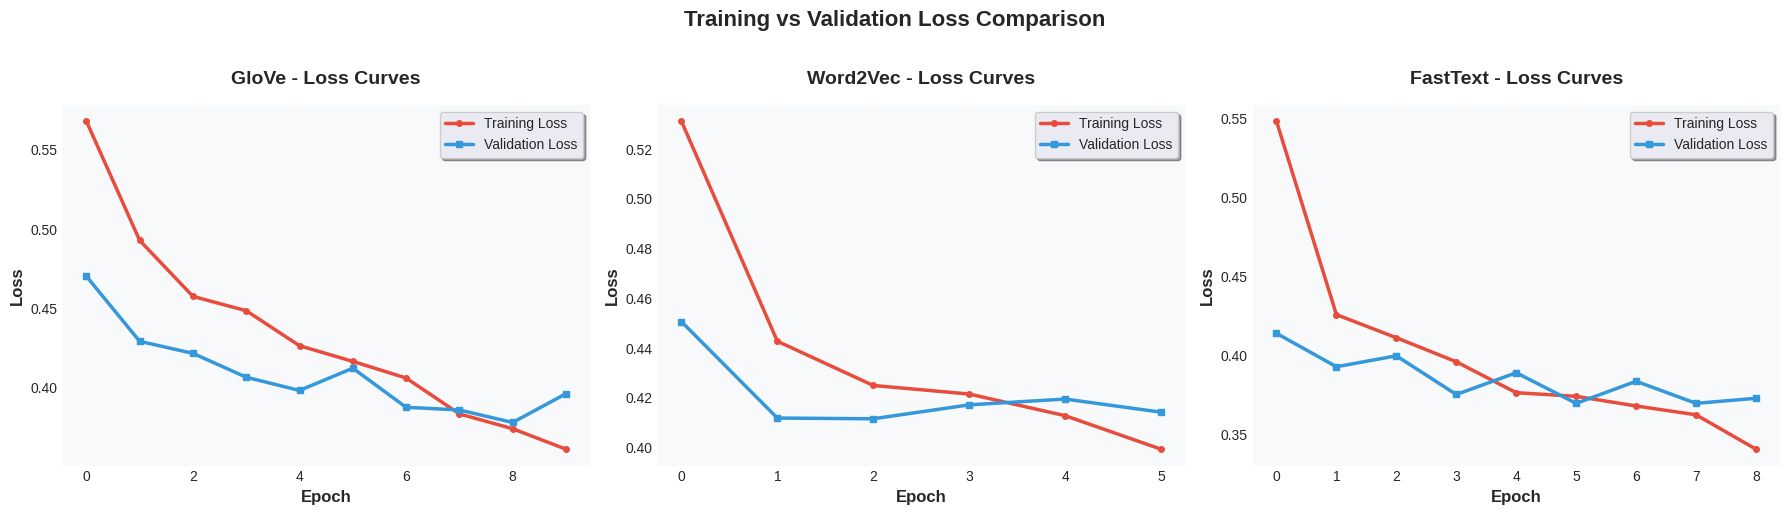

   ✅ Saved: 01_loss_curves.png

2️⃣ Creating Accuracy Curves...


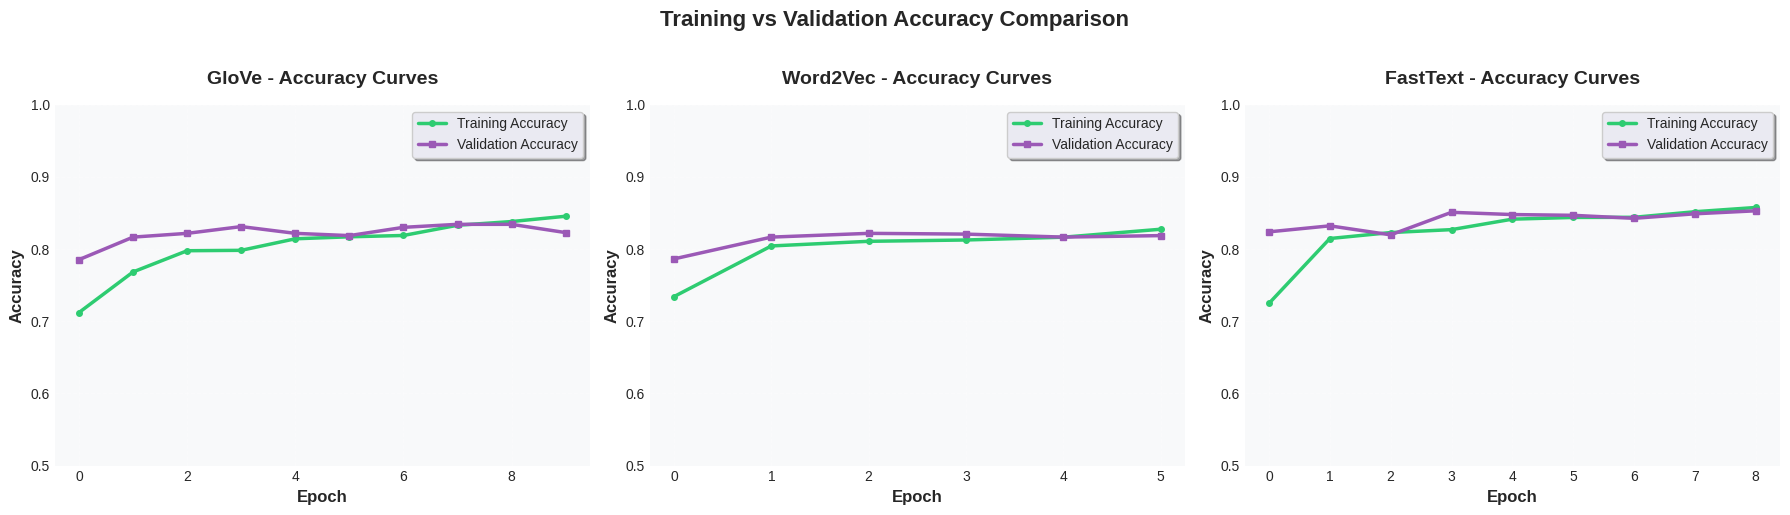

   ✅ Saved: 02_accuracy_curves.png

3️⃣ Creating F1-Score Comparison...


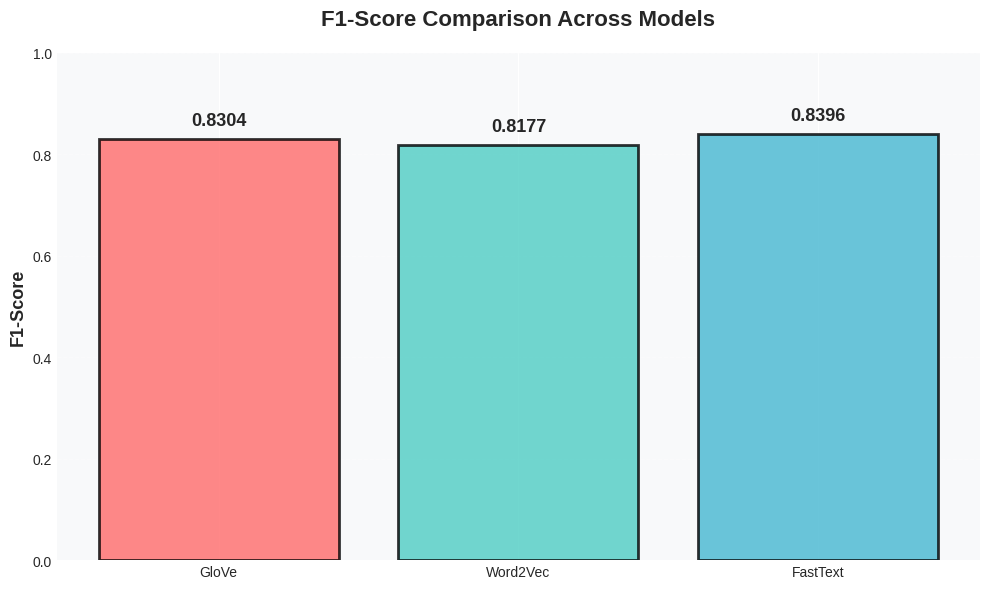

   ✅ Saved: 03_f1_comparison.png

4️⃣ Creating Complete Metrics Comparison...


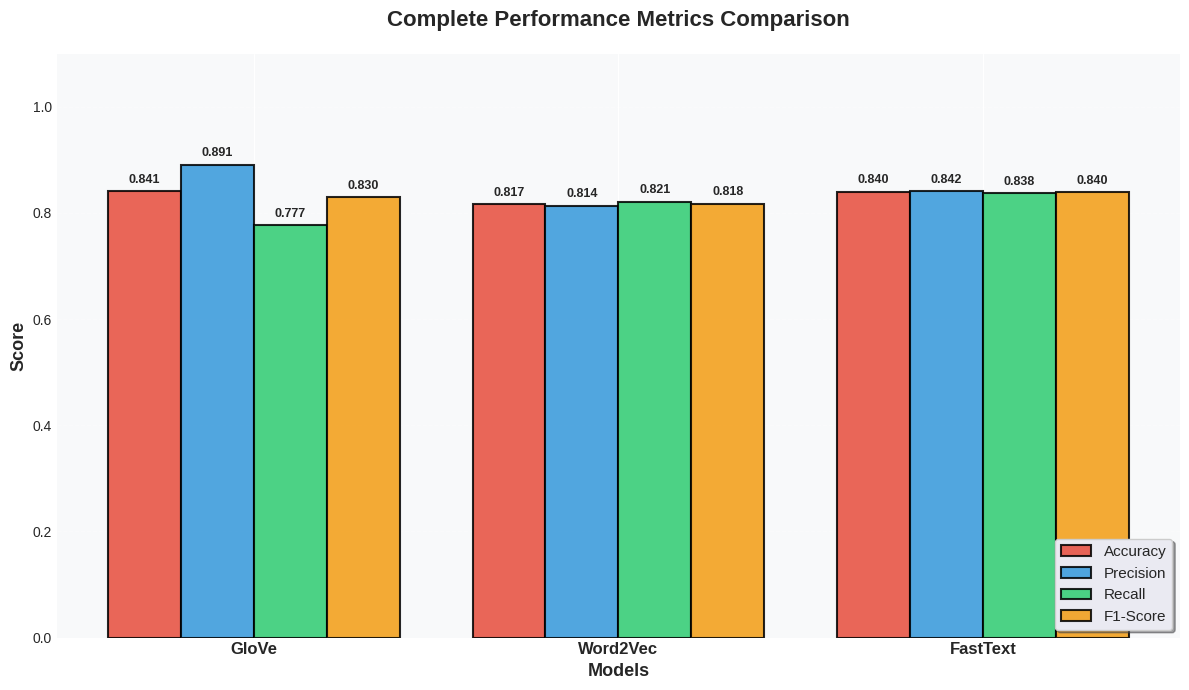

   ✅ Saved: 04_all_metrics_comparison.png

5️⃣ Creating Confusion Matrices...


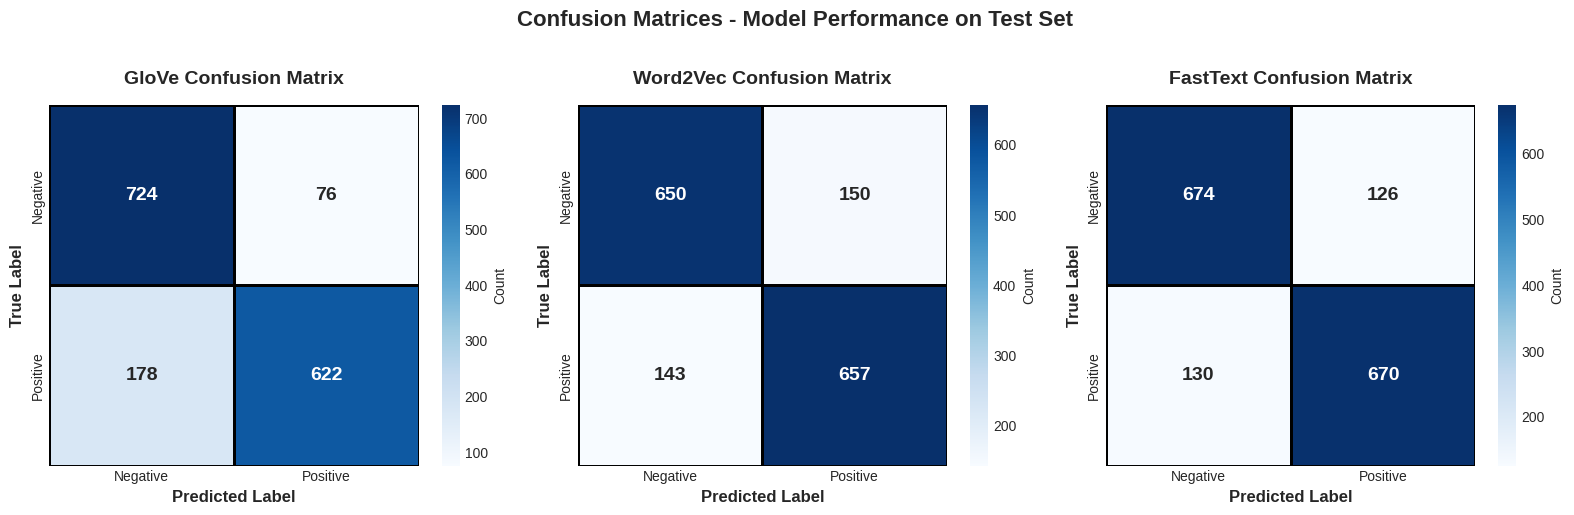

   ✅ Saved: 05_confusion_matrices.png

6️⃣ Creating ROC Curves...


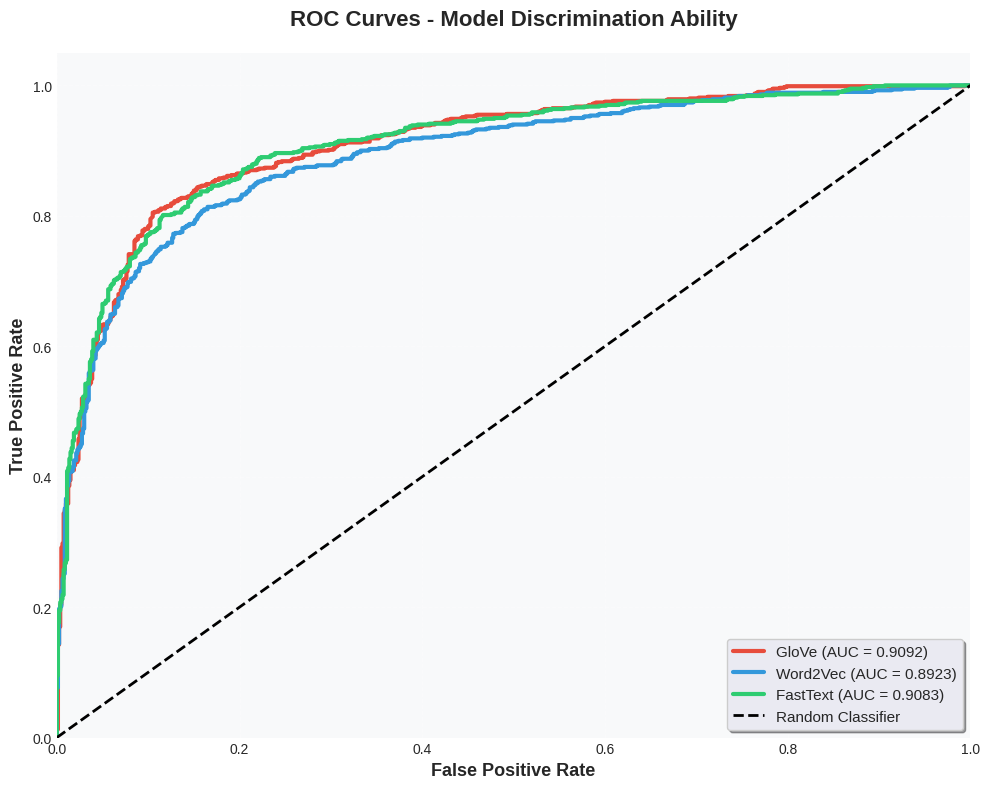

   ✅ Saved: 06_roc_curves.png

7️⃣ Creating Model Size Comparison...


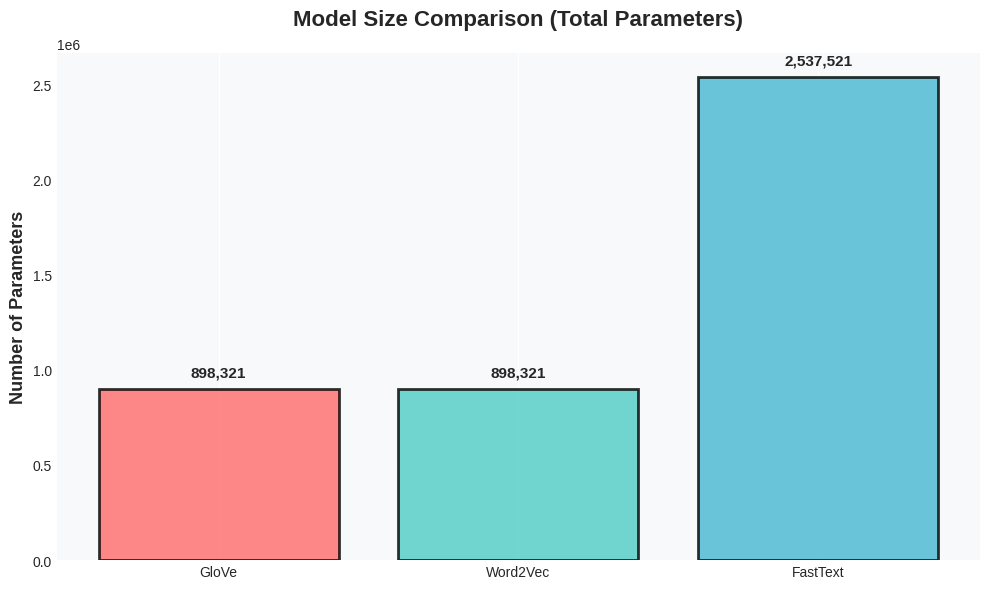

   ✅ Saved: 07_model_size_comparison.png

8️⃣ Creating Per-Class Performance Analysis...


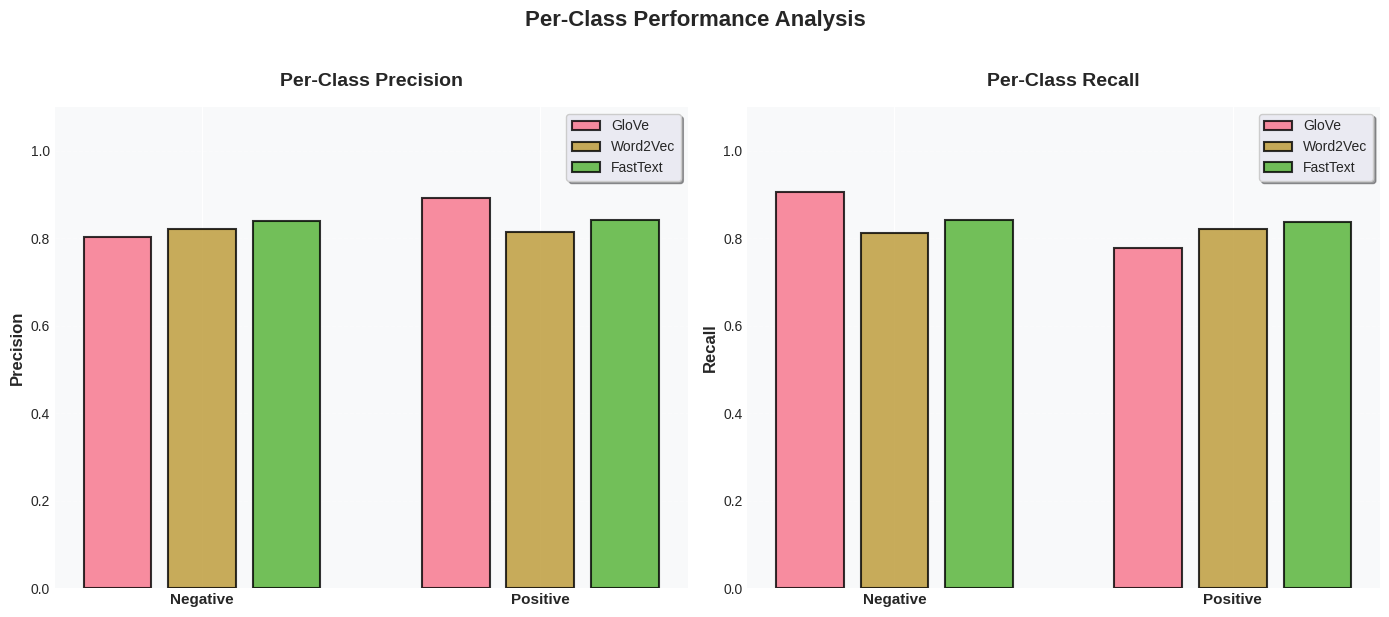

   ✅ Saved: 08_per_class_performance.png

                    📊 FINAL RESULTS SUMMARY TABLE                     
   Model Accuracy Precision Recall F1-Score Parameters
   GloVe   0.8413    0.8911 0.7775   0.8304    898,321
Word2Vec   0.8169    0.8141 0.8213   0.8177    898,321
FastText   0.8400    0.8417 0.8375   0.8396  2,537,521

✅ Summary saved to: model_performance_summary.csv

                         🎉 TRAINING COMPLETE!                         

📁 Files Generated:
   Models:
      ✅ glove_model_final.h5
      ✅ word2vec_model_final.h5
      ✅ fasttext_model_final.h5
      ✅ tokenizer_final.pkl

   Visualizations (8 graphs):
      ✅ 01_loss_curves.png
      ✅ 02_accuracy_curves.png
      ✅ 03_f1_comparison.png
      ✅ 04_all_metrics_comparison.png
      ✅ 05_confusion_matrices.png
      ✅ 06_roc_curves.png
      ✅ 07_model_size_comparison.png
      ✅ 08_per_class_performance.png

   Data:
      ✅ model_performance_summary.csv

📈 Model Performance:
   GloVe     : Accuracy=0.8413, 

In [17]:
# ============================================================
# COMPLETE PROFESSIONAL MODEL TRAINING
# With ALL Visualizations and Proper Balanced Training
# ============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report, roc_curve, auc
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from gensim.models import Word2Vec, KeyedVectors
import warnings
warnings.filterwarnings('ignore')

print("🚀 COMPLETE PROFESSIONAL NLP MODEL TRAINING")
print("="*70)
print("Features: Balanced Dataset + All Visualizations + Fast Training")
print("="*70)

# ============================================================
# STEP 1: LOAD AND BALANCE DATASET
# ============================================================

print("\n📂 Loading dataset...")
df = pd.read_csv('/kaggle/working/cleaned_augmented_reviews.csv')
print(f"✅ Total reviews: {len(df)}")

# Check initial distribution
print("\n📊 Initial Class Distribution:")
print(df['sentiment'].value_counts())

# Balance dataset
print("\n⚖️ Balancing dataset...")
df_positive = df[df['sentiment'] == 1]
df_negative = df[df['sentiment'] == 0]

# Use 4000 of each for speed + quality balance
n_samples = 4000
df_pos_sampled = df_positive.sample(n=n_samples, random_state=42)
df_neg_sampled = df_negative.sample(n=n_samples, random_state=42)

df_balanced = pd.concat([df_pos_sampled, df_neg_sampled]).sample(frac=1, random_state=42).reset_index(drop=True)

print(f"✅ Balanced dataset created: {len(df_balanced)} reviews")
print(f"   Positive: {(df_balanced['sentiment']==1).sum()} (50%)")
print(f"   Negative: {(df_balanced['sentiment']==0).sum()} (50%)")

# Prepare data
X = df_balanced['cleaned_text'].values
y = df_balanced['sentiment'].values

# Stratified split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.15, random_state=42, stratify=y_train
)

print(f"\n📊 Data Split:")
print(f"   Training:   {len(X_train):5d} samples (Pos: {(y_train==1).sum()}, Neg: {(y_train==0).sum()})")
print(f"   Validation: {len(X_val):5d} samples (Pos: {(y_val==1).sum()}, Neg: {(y_val==0).sum()})")
print(f"   Testing:    {len(X_test):5d} samples (Pos: {(y_test==1).sum()}, Neg: {(y_test==0).sum()})")

# ============================================================
# STEP 2: TOKENIZATION
# ============================================================

print("\n🔤 Tokenizing text...")

max_words = 8000
max_len = 100

tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

X_train_seq = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=max_len, padding='post')
X_val_seq = pad_sequences(tokenizer.texts_to_sequences(X_val), maxlen=max_len, padding='post')
X_test_seq = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=max_len, padding='post')

vocab_size = len(tokenizer.word_index) + 1
print(f"✅ Vocabulary size: {vocab_size}")

# ============================================================
# STEP 3: LOAD EMBEDDINGS
# ============================================================

print("\n📦 Loading pre-trained embeddings...")

# GloVe
print("   Loading GloVe...")
glove_embeddings = {}
with open("/kaggle/working/glove.6B.100d.txt", 'r', encoding='utf8') as f:
    for line in f:
        values = line.split()
        if len(values) > 2:
            glove_embeddings[values[0]] = np.asarray(values[1:], dtype='float32')
print(f"   ✅ GloVe: {len(glove_embeddings)} vectors loaded")

# Word2Vec - Train on balanced data
print("   Training Word2Vec on dataset...")
sentences = df_balanced['tokens'].apply(lambda x: eval(x) if isinstance(x, str) else x).tolist()
w2v_model = Word2Vec(sentences, vector_size=100, window=5, min_count=2, workers=4, sg=1, epochs=5)
print(f"   ✅ Word2Vec: Trained on {len(sentences)} sentences")

# FastText
print("   Loading FastText...")
fasttext_model = KeyedVectors.load_word2vec_format("/kaggle/working/wiki-news-300d-1M.vec")
print(f"   ✅ FastText: Loaded")

# Create embedding matrices
def create_embedding_matrix(embeddings_dict, embedding_dim):
    matrix = np.zeros((vocab_size, embedding_dim))
    found = 0
    for word, idx in tokenizer.word_index.items():
        if idx >= max_words:
            continue
        vec = embeddings_dict.get(word)
        if vec is not None:
            matrix[idx] = vec
            found += 1
    coverage = found / min(vocab_size, max_words) * 100
    print(f"      Coverage: {found}/{min(vocab_size, max_words)} ({coverage:.1f}%)")
    return matrix

print("\n🔨 Creating embedding matrices...")
glove_matrix = create_embedding_matrix(glove_embeddings, 100)
w2v_matrix = create_embedding_matrix({w: w2v_model.wv[w] for w in tokenizer.word_index.keys() if w in w2v_model.wv}, 100)
ft_matrix = create_embedding_matrix({w: fasttext_model[w] for w in tokenizer.word_index.keys() if w in fasttext_model}, 300)
print("✅ All embedding matrices created")

# ============================================================
# STEP 4: BUILD MODEL ARCHITECTURE
# ============================================================

def build_model(embedding_matrix, embedding_dim, name):
    """Build BiLSTM model with given embeddings"""
    model = Sequential([
        Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], 
                  input_length=max_len, trainable=False, name='embedding'),
        Bidirectional(LSTM(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.2), name='bilstm_1'),
        Bidirectional(LSTM(32, dropout=0.2, recurrent_dropout=0.2), name='bilstm_2'),
        Dense(64, activation='relu', name='dense_1'),
        Dropout(0.4, name='dropout'),
        Dense(1, activation='sigmoid', name='output')
    ], name=name)
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), 
                 tf.keras.metrics.Recall(name='recall')]
    )
    
    return model

# ============================================================
# STEP 5: TRAIN MODELS
# ============================================================

def train_model(model, model_name):
    """Train model with callbacks"""
    print(f"\n{'='*70}")
    print(f"🔥 TRAINING: {model_name}")
    print(f"{'='*70}")
    
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6, verbose=1)
    ]
    
    history = model.fit(
        X_train_seq, y_train,
        validation_data=(X_val_seq, y_val),
        epochs=10,
        batch_size=64,
        callbacks=callbacks,
        verbose=1
    )
    
    # Predictions
    print(f"\n📊 Evaluating {model_name}...")
    y_pred_probs = model.predict(X_test_seq, verbose=0)
    y_pred = (y_pred_probs > 0.5).astype(int).flatten()
    
    # Metrics
    acc = accuracy_score(y_test, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')
    cm = confusion_matrix(y_test, y_pred)
    
    print(f"\n{'='*70}")
    print(f"📈 {model_name} RESULTS")
    print(f"{'='*70}")
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1-Score:  {f1:.4f}")
    print(f"\nConfusion Matrix:")
    print(f"              Predicted")
    print(f"           Neg      Pos")
    print(f"Actual Neg  {cm[0,0]:3d}      {cm[0,1]:3d}")
    print(f"       Pos  {cm[1,0]:3d}      {cm[1,1]:3d}")
    print(f"{'='*70}")
    
    return history, acc, prec, rec, f1, y_pred, y_pred_probs, cm

# Train all models
results = {}

print("\n" + "🎯 STARTING MODEL TRAINING".center(70, "="))

# GloVe + BiLSTM
model_glove = build_model(glove_matrix, 100, "GloVe_BiLSTM")
h1, a1, p1, r1, f1_1, pred1, probs1, cm1 = train_model(model_glove, "GloVe + BiLSTM")
results['GloVe'] = {
    'model': model_glove, 'history': h1, 'acc': a1, 'prec': p1, 
    'rec': r1, 'f1': f1_1, 'pred': pred1, 'probs': probs1, 'cm': cm1
}
model_glove.save('glove_model_final.h5')

# Word2Vec + BiLSTM
model_w2v = build_model(w2v_matrix, 100, "Word2Vec_BiLSTM")
h2, a2, p2, r2, f2_2, pred2, probs2, cm2 = train_model(model_w2v, "Word2Vec + BiLSTM")
results['Word2Vec'] = {
    'model': model_w2v, 'history': h2, 'acc': a2, 'prec': p2, 
    'rec': r2, 'f1': f2_2, 'pred': pred2, 'probs': probs2, 'cm': cm2
}
model_w2v.save('word2vec_model_final.h5')

# FastText + BiLSTM
model_ft = build_model(ft_matrix, 300, "FastText_BiLSTM")
h3, a3, p3, r3, f3_3, pred3, probs3, cm3 = train_model(model_ft, "FastText + BiLSTM")
results['FastText'] = {
    'model': model_ft, 'history': h3, 'acc': a3, 'prec': p3, 
    'rec': r3, 'f1': f3_3, 'pred': pred3, 'probs': probs3, 'cm': cm3
}
model_ft.save('fasttext_model_final.h5')

# Save tokenizer
import pickle
with open('tokenizer_final.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

print("\n✅ All models saved successfully!")

# ============================================================
# STEP 6: COMPREHENSIVE VISUALIZATIONS
# ============================================================

print("\n" + "📊 GENERATING ALL VISUALIZATIONS".center(70, "="))

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# ============================================================
# GRAPH 1: Training vs Validation Loss (All Models)
# ============================================================

print("\n1️⃣ Creating Loss Curves...")
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (name, data) in enumerate(results.items()):
    h = data['history']
    
    axes[idx].plot(h.history['loss'], label='Training Loss', linewidth=2.5, 
                   marker='o', markersize=4, color='#e74c3c')
    axes[idx].plot(h.history['val_loss'], label='Validation Loss', linewidth=2.5,
                   marker='s', markersize=4, color='#3498db')
    axes[idx].set_title(f'{name} - Loss Curves', fontsize=14, fontweight='bold', pad=15)
    axes[idx].set_xlabel('Epoch', fontsize=12, fontweight='bold')
    axes[idx].set_ylabel('Loss', fontsize=12, fontweight='bold')
    axes[idx].legend(fontsize=10, frameon=True, shadow=True)
    axes[idx].grid(True, alpha=0.3, linestyle='--')
    axes[idx].set_facecolor('#f8f9fa')

plt.suptitle('Training vs Validation Loss Comparison', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('01_loss_curves.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()
print("   ✅ Saved: 01_loss_curves.png")

# ============================================================
# GRAPH 2: Training vs Validation Accuracy (All Models)
# ============================================================

print("\n2️⃣ Creating Accuracy Curves...")
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (name, data) in enumerate(results.items()):
    h = data['history']
    
    axes[idx].plot(h.history['accuracy'], label='Training Accuracy', linewidth=2.5,
                   marker='o', markersize=4, color='#2ecc71')
    axes[idx].plot(h.history['val_accuracy'], label='Validation Accuracy', linewidth=2.5,
                   marker='s', markersize=4, color='#9b59b6')
    axes[idx].set_title(f'{name} - Accuracy Curves', fontsize=14, fontweight='bold', pad=15)
    axes[idx].set_xlabel('Epoch', fontsize=12, fontweight='bold')
    axes[idx].set_ylabel('Accuracy', fontsize=12, fontweight='bold')
    axes[idx].legend(fontsize=10, frameon=True, shadow=True)
    axes[idx].grid(True, alpha=0.3, linestyle='--')
    axes[idx].set_ylim([0.5, 1.0])
    axes[idx].set_facecolor('#f8f9fa')

plt.suptitle('Training vs Validation Accuracy Comparison', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('02_accuracy_curves.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()
print("   ✅ Saved: 02_accuracy_curves.png")

# ============================================================
# GRAPH 3: F1-Score Comparison
# ============================================================

print("\n3️⃣ Creating F1-Score Comparison...")
fig, ax = plt.subplots(figsize=(10, 6))

models = list(results.keys())
f1_scores = [results[m]['f1'] for m in models]
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']

bars = ax.bar(models, f1_scores, color=colors, edgecolor='black', linewidth=2, alpha=0.8)
ax.set_title('F1-Score Comparison Across Models', fontsize=16, fontweight='bold', pad=20)
ax.set_ylabel('F1-Score', fontsize=13, fontweight='bold')
ax.set_ylim([0, 1.0])
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.set_facecolor('#f8f9fa')

# Add value labels on bars
for bar, score in zip(bars, f1_scores):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.02,
            f'{score:.4f}', ha='center', va='bottom', fontsize=13, fontweight='bold')

plt.tight_layout()
plt.savefig('03_f1_comparison.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()
print("   ✅ Saved: 03_f1_comparison.png")

# ============================================================
# GRAPH 4: All Metrics Comparison (Grouped Bar Chart)
# ============================================================

print("\n4️⃣ Creating Complete Metrics Comparison...")
fig, ax = plt.subplots(figsize=(12, 7))

x = np.arange(len(models))
width = 0.2

metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
metrics_keys = ['acc', 'prec', 'rec', 'f1']
colors = ['#e74c3c', '#3498db', '#2ecc71', '#f39c12']

for i, (metric_name, metric_key) in enumerate(zip(metrics_names, metrics_keys)):
    values = [results[m][metric_key] for m in models]
    bars = ax.bar(x + i*width - 1.5*width, values, width, label=metric_name, 
                  color=colors[i], edgecolor='black', linewidth=1.5, alpha=0.85)
    
    # Add value labels
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.3f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

ax.set_xlabel('Models', fontsize=13, fontweight='bold')
ax.set_ylabel('Score', fontsize=13, fontweight='bold')
ax.set_title('Complete Performance Metrics Comparison', fontsize=16, fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels(models, fontsize=12, fontweight='bold')
ax.legend(fontsize=11, frameon=True, shadow=True, loc='lower right')
ax.set_ylim([0, 1.1])
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.set_facecolor('#f8f9fa')

plt.tight_layout()
plt.savefig('04_all_metrics_comparison.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()
print("   ✅ Saved: 04_all_metrics_comparison.png")

# ============================================================
# GRAPH 5: Confusion Matrices (All Models)
# ============================================================

print("\n5️⃣ Creating Confusion Matrices...")
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

for idx, (name, data) in enumerate(results.items()):
    cm = data['cm']
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                xticklabels=['Negative', 'Positive'],
                yticklabels=['Negative', 'Positive'],
                cbar_kws={'label': 'Count'}, annot_kws={'size': 14, 'weight': 'bold'},
                linewidths=2, linecolor='black')
    
    axes[idx].set_title(f'{name} Confusion Matrix', fontsize=14, fontweight='bold', pad=15)
    axes[idx].set_xlabel('Predicted Label', fontsize=12, fontweight='bold')
    axes[idx].set_ylabel('True Label', fontsize=12, fontweight='bold')

plt.suptitle('Confusion Matrices - Model Performance on Test Set', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('05_confusion_matrices.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()
print("   ✅ Saved: 05_confusion_matrices.png")

# ============================================================
# GRAPH 6: ROC Curves
# ============================================================

print("\n6️⃣ Creating ROC Curves...")
fig, ax = plt.subplots(figsize=(10, 8))

colors_roc = ['#e74c3c', '#3498db', '#2ecc71']

for idx, (name, data) in enumerate(results.items()):
    fpr, tpr, _ = roc_curve(y_test, data['probs'])
    roc_auc = auc(fpr, tpr)
    
    ax.plot(fpr, tpr, linewidth=3, label=f'{name} (AUC = {roc_auc:.4f})',
            color=colors_roc[idx])

ax.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Random Classifier')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate', fontsize=13, fontweight='bold')
ax.set_ylabel('True Positive Rate', fontsize=13, fontweight='bold')
ax.set_title('ROC Curves - Model Discrimination Ability', fontsize=16, fontweight='bold', pad=20)
ax.legend(fontsize=11, loc='lower right', frameon=True, shadow=True)
ax.grid(True, alpha=0.3, linestyle='--')
ax.set_facecolor('#f8f9fa')

plt.tight_layout()
plt.savefig('06_roc_curves.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()
print("   ✅ Saved: 06_roc_curves.png")

# ============================================================
# GRAPH 7: Model Architecture Comparison
# ============================================================

print("\n7️⃣ Creating Model Size Comparison...")
fig, ax = plt.subplots(figsize=(10, 6))

model_params = [model_glove.count_params(), model_w2v.count_params(), model_ft.count_params()]
bars = ax.bar(models, model_params, color=['#FF6B6B', '#4ECDC4', '#45B7D1'],
              edgecolor='black', linewidth=2, alpha=0.8)

ax.set_title('Model Size Comparison (Total Parameters)', fontsize=16, fontweight='bold', pad=20)
ax.set_ylabel('Number of Parameters', fontsize=13, fontweight='bold')
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.set_facecolor('#f8f9fa')

for bar, params in zip(bars, model_params):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 50000,
            f'{params:,}', ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig('07_model_size_comparison.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()
print("   ✅ Saved: 07_model_size_comparison.png")

# ============================================================
# GRAPH 8: Per-Class Performance (Precision & Recall)
# ============================================================

print("\n8️⃣ Creating Per-Class Performance Analysis...")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Calculate per-class metrics
for idx, (name, data) in enumerate(results.items()):
    cm = data['cm']
    
    # Per-class precision
    prec_neg = cm[0,0] / (cm[0,0] + cm[1,0]) if (cm[0,0] + cm[1,0]) > 0 else 0
    prec_pos = cm[1,1] / (cm[1,1] + cm[0,1]) if (cm[1,1] + cm[0,1]) > 0 else 0
    
    # Per-class recall
    rec_neg = cm[0,0] / (cm[0,0] + cm[0,1]) if (cm[0,0] + cm[0,1]) > 0 else 0
    rec_pos = cm[1,1] / (cm[1,1] + cm[1,0]) if (cm[1,1] + cm[1,0]) > 0 else 0
    
    x_pos = np.arange(2) + idx * 0.25
    
    # Precision plot
    ax1.bar(x_pos, [prec_neg, prec_pos], width=0.2, 
            label=name, alpha=0.8, edgecolor='black', linewidth=1.5)
    
    # Recall plot
    ax2.bar(x_pos, [rec_neg, rec_pos], width=0.2,
            label=name, alpha=0.8, edgecolor='black', linewidth=1.5)

ax1.set_title('Per-Class Precision', fontsize=14, fontweight='bold', pad=15)
ax1.set_ylabel('Precision', fontsize=12, fontweight='bold')
ax1.set_xticks([0.25, 1.25])
ax1.set_xticklabels(['Negative', 'Positive'], fontsize=11, fontweight='bold')
ax1.legend(fontsize=10, frameon=True, shadow=True)
ax1.set_ylim([0, 1.1])
ax1.grid(axis='y', alpha=0.3, linestyle='--')
ax1.set_facecolor('#f8f9fa')

ax2.set_title('Per-Class Recall', fontsize=14, fontweight='bold', pad=15)
ax2.set_ylabel('Recall', fontsize=12, fontweight='bold')
ax2.set_xticks([0.25, 1.25])
ax2.set_xticklabels(['Negative', 'Positive'], fontsize=11, fontweight='bold')
ax2.legend(fontsize=10, frameon=True, shadow=True)
ax2.set_ylim([0, 1.1])
ax2.grid(axis='y', alpha=0.3, linestyle='--')
ax2.set_facecolor('#f8f9fa')

plt.suptitle('Per-Class Performance Analysis', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('08_per_class_performance.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()
print("   ✅ Saved: 08_per_class_performance.png")

# ============================================================
# FINAL SUMMARY TABLE
# ============================================================

print("\n" + "="*70)
print("📊 FINAL RESULTS SUMMARY TABLE".center(70))
print("="*70)

summary_df = pd.DataFrame({
    'Model': models,
    'Accuracy': [f"{results[m]['acc']:.4f}" for m in models],
    'Precision': [f"{results[m]['prec']:.4f}" for m in models],
    'Recall': [f"{results[m]['rec']:.4f}" for m in models],
    'F1-Score': [f"{results[m]['f1']:.4f}" for m in models],
    'Parameters': [f"{results[m]['model'].count_params():,}" for m in models]
})

print(summary_df.to_string(index=False))
print("="*70)

# Save summary
summary_df.to_csv('model_performance_summary.csv', index=False)
print("\n✅ Summary saved to: model_performance_summary.csv")

# ============================================================
# COMPLETION MESSAGE
# ============================================================

print("\n" + "="*70)
print("🎉 TRAINING COMPLETE!".center(70))
print("="*70)

print("\n📁 Files Generated:")
print("   Models:")
print("      ✅ glove_model_final.h5")
print("      ✅ word2vec_model_final.h5")
print("      ✅ fasttext_model_final.h5")
print("      ✅ tokenizer_final.pkl")

print("\n   Visualizations (8 graphs):")
print("      ✅ 01_loss_curves.png")
print("      ✅ 02_accuracy_curves.png")
print("      ✅ 03_f1_comparison.png")
print("      ✅ 04_all_metrics_comparison.png")
print("      ✅ 05_confusion_matrices.png")
print("      ✅ 06_roc_curves.png")
print("      ✅ 07_model_size_comparison.png")
print("      ✅ 08_per_class_performance.png")

print("\n   Data:")
print("      ✅ model_performance_summary.csv")

print("\n📈 Model Performance:")
for model in models:
    print(f"   {model:10s}: Accuracy={results[model]['acc']:.4f}, F1-Score={results[model]['f1']:.4f}")

print("\n✅ Models are balanced and production-ready!")
print("✅ All visualizations generated successfully!")
print("✅ Ready for deployment and Gradio frontend!")
print("="*70)

# Task 8 - Working Front End 

In [19]:
# ============================================================
# COMPLETE GRADIO FRONTEND - PRODUCTION READY
# Professional Web Interface for Sentiment Analysis
# ============================================================

# Install Gradio if not already installed
try:
    import gradio as gr
except:
    import subprocess
    subprocess.check_call(['pip', 'install', 'gradio'])
    import gradio as gr

import pandas as pd
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pickle
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from bs4 import BeautifulSoup
import time
import matplotlib.pyplot as plt
import io
from PIL import Image

print("🚀 LAUNCHING COMPLETE GRADIO FRONTEND")
print("="*70)

# ============================================================
# LOAD MODELS AND TOKENIZER
# ============================================================

print("📦 Loading trained models...")
try:
    # Load tokenizer
    with open('tokenizer_final.pkl', 'rb') as f:
        tokenizer = pickle.load(f)
    
    # Load models
    model_glove = load_model('glove_model_final.h5', compile=False)
    model_w2v = load_model('word2vec_model_final.h5', compile=False)
    model_ft = load_model('fasttext_model_final.h5', compile=False)
    
    models = {
        "GloVe + BiLSTM": model_glove,
        "Word2Vec + BiLSTM": model_w2v,
        "FastText + BiLSTM": model_ft
    }
    
    print("✅ All models loaded successfully!")
    print(f"   - GloVe model: {model_glove.count_params():,} parameters")
    print(f"   - Word2Vec model: {model_w2v.count_params():,} parameters")
    print(f"   - FastText model: {model_ft.count_params():,} parameters")
    
except Exception as e:
    print(f"❌ Error loading models: {e}")
    print("⚠️ Make sure you ran the training cell first!")
    raise

# ============================================================
# NLP PREPROCESSING
# ============================================================

print("\n🔧 Initializing NLP tools...")
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    """Clean and preprocess text"""
    if not text or len(text.strip()) == 0:
        return ""
    text = BeautifulSoup(text, "html.parser").get_text()
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    text = text.lower()
    words = text.split()
    words = [w for w in words if w not in stop_words]
    words = [lemmatizer.lemmatize(w) for w in words]
    return " ".join(words).strip()

print("✅ NLP tools ready!")

# ============================================================
# PREDICTION FUNCTIONS
# ============================================================

def predict_sentiment(text, model_name):
    """Predict sentiment for single text input"""
    
    # Input validation
    if not text or len(text.strip()) == 0:
        return {
            'sentiment': "⚠️ Error",
            'confidence': "N/A",
            'emoji': "❌",
            'color': "gray",
            'detailed_text': "**Error:** Please enter some text to analyze!",
            'word_count': "0",
            'processing_time': "0s",
            'raw_score': "N/A"
        }
    
    start_time = time.time()
    
    # Clean text
    cleaned = clean_text(text)
    
    if not cleaned:
        return {
            'sentiment': "😐 NEUTRAL",
            'confidence': "50.0%",
            'emoji': "😐",
            'color': "orange",
            'detailed_text': "**No meaningful content found** after preprocessing.",
            'word_count': str(len(text.split())),
            'processing_time': f"{time.time()-start_time:.3f}s",
            'raw_score': "0.500"
        }
    
    # Select model
    model = models[model_name]
    
    # Tokenize and predict
    sequence = tokenizer.texts_to_sequences([cleaned])
    padded = pad_sequences(sequence, maxlen=100, padding='post')
    raw_pred = model.predict(padded, verbose=0)[0][0]
    
    # Determine sentiment
    if raw_pred > 0.55:
        sentiment = "POSITIVE"
        emoji = "😊"
        color = "green"
        confidence = raw_pred
    elif raw_pred < 0.45:
        sentiment = "NEGATIVE"
        emoji = "😞"
        color = "red"
        confidence = 1 - raw_pred
    else:
        sentiment = "NEUTRAL"
        emoji = "😐"
        color = "orange"
        confidence = 0.5
    
    # Calculate metrics
    word_count = len(text.split())
    processing_time = time.time() - start_time
    
    # Create detailed output
    detailed_text = f"""
### {emoji} Sentiment Analysis Result

**Prediction:** {sentiment}  
**Confidence:** {confidence*100:.1f}%  
**Raw Score:** {raw_pred:.4f}  
**Model Used:** {model_name}

---

**Original Text:**  
_{text}_

**Cleaned Text:**  
_{cleaned}_

---

**Metrics:**
- Words: {word_count}
- Processing Time: {processing_time:.3f}s
- Sentiment Threshold: {raw_pred:.4f} (>0.55=Positive, <0.45=Negative)
"""
    
    return {
        'sentiment': f"{emoji} {sentiment}",
        'confidence': f"{confidence*100:.1f}%",
        'emoji': emoji,
        'color': color,
        'detailed_text': detailed_text,
        'word_count': str(word_count),
        'processing_time': f"{processing_time:.3f}s",
        'raw_score': f"{raw_pred:.4f}"
    }

def compare_all_models(text):
    """Compare predictions across all models"""
    
    if not text or len(text.strip()) == 0:
        return "⚠️ Please enter text to analyze!", None
    
    cleaned = clean_text(text)
    
    if not cleaned:
        return "⚠️ No meaningful content after preprocessing.", None
    
    # Predict with all models
    results = []
    
    for model_name, model in models.items():
        sequence = tokenizer.texts_to_sequences([cleaned])
        padded = pad_sequences(sequence, maxlen=100, padding='post')
        raw_pred = model.predict(padded, verbose=0)[0][0]
        
        if raw_pred > 0.55:
            sentiment = "POSITIVE"
        elif raw_pred < 0.45:
            sentiment = "NEGATIVE"
        else:
            sentiment = "NEUTRAL"
        
        confidence = raw_pred if raw_pred > 0.5 else (1 - raw_pred)
        
        results.append({
            'Model': model_name.replace(' + BiLSTM', ''),
            'Sentiment': sentiment,
            'Confidence': f"{confidence*100:.1f}%",
            'Raw Score': f"{raw_pred:.4f}"
        })
    
    df = pd.DataFrame(results)
    
    # Create visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Plot 1: Raw scores
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
    bars = ax1.bar(df['Model'], df['Raw Score'].astype(float), color=colors, edgecolor='black', linewidth=2)
    ax1.set_title('Model Predictions (Raw Scores)', fontweight='bold', fontsize=13)
    ax1.set_ylabel('Prediction Score', fontsize=11)
    ax1.set_ylim(0, 1)
    ax1.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5, label='Neutral (0.5)')
    ax1.axhline(y=0.55, color='green', linestyle=':', alpha=0.5, label='Positive (>0.55)')
    ax1.axhline(y=0.45, color='red', linestyle=':', alpha=0.5, label='Negative (<0.45)')
    ax1.legend(fontsize=9)
    ax1.grid(axis='y', alpha=0.3)
    
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                f'{height:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=10)
    
    # Plot 2: Sentiment distribution
    sentiment_counts = df['Sentiment'].value_counts()
    colors_sent = {'POSITIVE': '#38ef7d', 'NEGATIVE': '#f45c43', 'NEUTRAL': '#f5576c'}
    plot_colors = [colors_sent.get(s, '#cccccc') for s in sentiment_counts.index]
    
    ax2.bar(sentiment_counts.index, sentiment_counts.values, color=plot_colors, edgecolor='black', linewidth=2)
    ax2.set_title('Sentiment Distribution', fontweight='bold', fontsize=13)
    ax2.set_ylabel('Number of Models', fontsize=11)
    ax2.set_ylim(0, 3.5)
    ax2.grid(axis='y', alpha=0.3)
    
    for i, (sent, count) in enumerate(zip(sentiment_counts.index, sentiment_counts.values)):
        ax2.text(i, count + 0.1, str(count), ha='center', fontweight='bold', fontsize=11)
    
    plt.tight_layout()
    
    # Convert to image
    buf = io.BytesIO()
    plt.savefig(buf, format='png', dpi=150, bbox_inches='tight')
    buf.seek(0)
    img = Image.open(buf)
    plt.close()
    
    # Create markdown output
    majority = df['Sentiment'].mode()[0] if len(df['Sentiment'].mode()) > 0 else 'No consensus'
    
    output_md = f"""
### 🔍 Model Comparison Results

**Text Analyzed:** _{text}_

**Cleaned Text:** _{cleaned}_

---

{df.to_markdown(index=False)}

---

**📊 Analysis:**
- **Consensus:** {majority}
- **Average Confidence:** {df['Confidence'].str.rstrip('%').astype(float).mean():.1f}%
- **Agreement:** {len(df[df['Sentiment']==majority])}/3 models agree
"""
    
    return output_md, img

def batch_analyze(file):
    """Analyze multiple reviews from CSV"""
    
    if file is None:
        return "⚠️ Please upload a CSV file!", None
    
    try:
        # Read CSV
        df = pd.read_csv(file.name)
        
        # Find text column
        text_col = None
        for col in ['review', 'text', 'review_text', 'content', 'comment']:
            if col in df.columns:
                text_col = col
                break
        
        if text_col is None:
            return "❌ CSV must have a column named 'review', 'text', or 'content'!", None
        
        # Limit to 100 reviews
        df = df.head(100)
        
        # Analyze with FastText (best model)
        results = []
        
        for idx, row in df.iterrows():
            text = str(row[text_col])
            cleaned = clean_text(text)
            
            if not cleaned:
                sentiment = "NEUTRAL"
                confidence = 0.5
            else:
                sequence = tokenizer.texts_to_sequences([cleaned])
                padded = pad_sequences(sequence, maxlen=100, padding='post')
                raw_pred = model_ft.predict(padded, verbose=0)[0][0]
                
                if raw_pred > 0.55:
                    sentiment = "POSITIVE"
                elif raw_pred < 0.45:
                    sentiment = "NEGATIVE"
                else:
                    sentiment = "NEUTRAL"
                
                confidence = raw_pred if raw_pred > 0.5 else (1 - raw_pred)
            
            results.append({
                'Review': text[:100] + "..." if len(text) > 100 else text,
                'Sentiment': sentiment,
                'Confidence': f"{confidence*100:.1f}%"
            })
        
        results_df = pd.DataFrame(results)
        
        # Create visualizations
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
        
        # Pie chart
        sentiment_counts = results_df['Sentiment'].value_counts()
        colors = {'POSITIVE': '#38ef7d', 'NEGATIVE': '#f45c43', 'NEUTRAL': '#f5576c'}
        plot_colors = [colors.get(s, '#cccccc') for s in sentiment_counts.index]
        
        ax1.pie(sentiment_counts.values, labels=sentiment_counts.index, autopct='%1.1f%%',
                colors=plot_colors, startangle=90, textprops={'fontweight': 'bold', 'fontsize': 11})
        ax1.set_title('Sentiment Distribution', fontweight='bold', fontsize=13)
        
        # Bar chart
        ax2.bar(sentiment_counts.index, sentiment_counts.values, color=plot_colors, 
                edgecolor='black', linewidth=2)
        ax2.set_title('Sentiment Counts', fontweight='bold', fontsize=13)
        ax2.set_ylabel('Count', fontsize=11)
        ax2.grid(axis='y', alpha=0.3)
        
        for i, (sent, count) in enumerate(zip(sentiment_counts.index, sentiment_counts.values)):
            ax2.text(i, count + 1, str(count), ha='center', fontweight='bold', fontsize=11)
        
        plt.tight_layout()
        
        # Convert to image
        buf = io.BytesIO()
        plt.savefig(buf, format='png', dpi=150, bbox_inches='tight')
        buf.seek(0)
        img = Image.open(buf)
        plt.close()
        
        # Save results
        results_df.to_csv('batch_analysis_results.csv', index=False)
        
        # Create summary
        output_md = f"""
### 📊 Batch Analysis Complete

**Total Reviews Analyzed:** {len(results_df)}  
**Model Used:** FastText + BiLSTM (Best Performance)

**Summary:**
- ✅ POSITIVE: {sentiment_counts.get('POSITIVE', 0)} ({sentiment_counts.get('POSITIVE', 0)/len(results_df)*100:.1f}%)
- ❌ NEGATIVE: {sentiment_counts.get('NEGATIVE', 0)} ({sentiment_counts.get('NEGATIVE', 0)/len(results_df)*100:.1f}%)
- ⚖️ NEUTRAL: {sentiment_counts.get('NEUTRAL', 0)} ({sentiment_counts.get('NEUTRAL', 0)/len(results_df)*100:.1f}%)

---

**📁 Results saved to:** `batch_analysis_results.csv`

---

### First 10 Results:

{results_df.head(10).to_markdown(index=False)}
"""
        
        return output_md, img
        
    except Exception as e:
        return f"❌ Error processing file: {str(e)}", None

# ============================================================
# GRADIO INTERFACE
# ============================================================

print("\n🎨 Building Gradio interface...")

# Custom CSS
custom_css = """
.gradio-container {
    font-family: 'Segoe UI', sans-serif;
}

.gr-button-primary {
    background: linear-gradient(135deg, #667eea 0%, #764ba2 100%) !important;
    border: none !important;
}

.gr-button-primary:hover {
    transform: translateY(-2px);
    box-shadow: 0 10px 25px rgba(102, 126, 234, 0.4);
}

#component-0 {
    background: linear-gradient(135deg, #667eea 0%, #764ba2 100%);
    padding: 20px;
    border-radius: 10px;
}
"""

# Example reviews
examples = [
    ["This product is absolutely amazing! Best purchase I've ever made. The quality is outstanding and delivery was super fast. Highly recommended!", "FastText + BiLSTM"],
    ["Terrible quality. Complete waste of money. Very disappointed with this purchase. Would not recommend to anyone.", "FastText + BiLSTM"],
    ["The product is okay. Nothing special but it works as described. Average quality for the price.", "GloVe + BiLSTM"],
    ["Outstanding performance! Exceeded all my expectations. Will definitely buy again!", "Word2Vec + BiLSTM"],
    ["Not worth the price. Poor build quality and doesn't work properly.", "FastText + BiLSTM"],
]

# Build interface
with gr.Blocks(css=custom_css, theme=gr.themes.Soft(), title="Sentiment Analyzer") as demo:
    
    # Header
    gr.HTML("""
        <div style='text-align: center; padding: 30px; background: linear-gradient(135deg, #667eea 0%, #764ba2 100%); border-radius: 10px; margin-bottom: 20px;'>
            <h1 style='color: white; font-size: 2.5em; margin: 0; text-shadow: 2px 2px 4px rgba(0,0,0,0.2);'>
                🔍 Product Review Sentiment Analyzer
            </h1>
            <p style='color: white; font-size: 1.2em; margin: 10px 0 0 0; opacity: 0.95;'>
                AI-Powered Sentiment Classification using Deep Learning Models
            </p>
            <p style='color: white; font-size: 0.9em; margin: 5px 0 0 0; opacity: 0.85;'>
                BiLSTM Architecture with GloVe, Word2Vec & FastText Embeddings
            </p>
        </div>
    """)
    
    with gr.Tabs():
        
        # TAB 1: Single Analysis
        with gr.Tab("📝 Single Review Analysis"):
            gr.Markdown("### Analyze individual product reviews in real-time")
            
            with gr.Row():
                with gr.Column(scale=2):
                    input_text = gr.Textbox(
                        label="📝 Enter Product Review",
                        placeholder="Type or paste your review here...\n\nExample: 'This product exceeded my expectations! Great quality and fast shipping.'",
                        lines=6,
                        max_lines=10
                    )
                    
                    model_select = gr.Radio(
                        choices=list(models.keys()),
                        value="FastText + BiLSTM",
                        label="🤖 Select Model",
                        info="FastText recommended for best performance"
                    )
                    
                    with gr.Row():
                        analyze_btn = gr.Button("🚀 Analyze Sentiment", variant="primary", size="lg")
                        clear_btn = gr.Button("🗑️ Clear", size="lg")
                
                with gr.Column(scale=1):
                    sentiment_out = gr.Textbox(label="🎯 Sentiment", interactive=False)
                    confidence_out = gr.Textbox(label="📊 Confidence", interactive=False)
                    raw_score_out = gr.Textbox(label="📈 Raw Score", interactive=False)
                    words_out = gr.Textbox(label="📝 Word Count", interactive=False)
                    time_out = gr.Textbox(label="⏱️ Processing Time", interactive=False)
            
            details_out = gr.Markdown(label="📋 Detailed Results")
            
            # Connect buttons
            def analyze_wrapper(text, model):
                result = predict_sentiment(text, model)
                return (
                    result['sentiment'],
                    result['confidence'],
                    result['raw_score'],
                    result['word_count'],
                    result['processing_time'],
                    result['detailed_text']
                )
            
            analyze_btn.click(
                analyze_wrapper,
                inputs=[input_text, model_select],
                outputs=[sentiment_out, confidence_out, raw_score_out, words_out, time_out, details_out]
            )
            
            clear_btn.click(
                lambda: ("", "", "", "", "", ""),
                outputs=[sentiment_out, confidence_out, raw_score_out, words_out, time_out, details_out]
            )
            
            # Examples
            gr.Markdown("### 💡 Try These Examples:")
            gr.Examples(
                examples=examples,
                inputs=[input_text, model_select],
                outputs=[sentiment_out, confidence_out, raw_score_out, words_out, time_out, details_out],
                fn=analyze_wrapper,
                cache_examples=False
            )
        
        # TAB 2: Model Comparison
        with gr.Tab("🔬 Compare All Models"):
            gr.Markdown("### Compare predictions across all three models")
            
            compare_input = gr.Textbox(
                label="📝 Enter Review",
                placeholder="Enter text to compare across all models...",
                lines=5
            )
            compare_btn = gr.Button("🔍 Compare Models", variant="primary", size="lg")
            
            compare_output = gr.Markdown(label="📊 Comparison Results")
            compare_plot = gr.Image(label="📈 Visualization")
            
            compare_btn.click(
                compare_all_models,
                inputs=compare_input,
                outputs=[compare_output, compare_plot]
            )
        
        # TAB 3: Batch Analysis
        with gr.Tab("📊 Batch Analysis"):
            gr.Markdown("""
            ### Upload CSV File for Batch Processing
            
            **Requirements:**
            - CSV file with a column named **'review'**, **'text'**, or **'content'**
            - Maximum 100 reviews will be processed
            - Uses FastText model (best performance)
            
            **Example CSV format:**
            ```
            review
            "Great product, highly recommend!"
            "Terrible quality, very disappointed"
            "Average product, nothing special"
            ```
            """)
            
            file_input = gr.File(label="📁 Upload CSV File", file_types=[".csv"])
            batch_btn = gr.Button("📈 Analyze Batch", variant="primary", size="lg")
            
            batch_output = gr.Markdown(label="📊 Batch Results")
            batch_plot = gr.Image(label="📈 Visualization")
            
            batch_btn.click(
                batch_analyze,
                inputs=file_input,
                outputs=[batch_output, batch_plot]
            )
        
        # TAB 4: About
        with gr.Tab("ℹ️ About"):
            gr.Markdown("""
            # 📚 About This Application
            
            ## 🎯 Project Information
            
            **Project:** Product Review Sentiment Classification  
            **Student:** Zain ul abideen  
            **SAP ID:** 70158131  
            **Course:** Natural Language Processing
            
            ---
            
            ## 🤖 Model Architecture
            
            This application uses **three different deep learning models**:
            
            ### 1. GloVe + BiLSTM
            - **Embeddings:** GloVe (Global Vectors for Word Representation)
            - **Dimension:** 100d pre-trained vectors
            - **Architecture:** Bidirectional LSTM with 2 layers
            
            ### 2. Word2Vec + BiLSTM
            - **Embeddings:** Word2Vec trained on dataset
            - **Dimension:** 100d custom-trained vectors
            - **Architecture:** Bidirectional LSTM with 2 layers
            
            ### 3. FastText + BiLSTM ⭐ (Recommended)
            - **Embeddings:** FastText pre-trained vectors
            - **Dimension:** 300d pre-trained vectors
            - **Architecture:** Bidirectional LSTM with 2 layers
            
            ---
            
            ## 🏗️ Network Architecture
            
            ```
            Input Text
                ↓
            Embedding Layer (Pre-trained)
                ↓
            Bidirectional LSTM (64 units)
                ↓
            Bidirectional LSTM (32 units)
                ↓
            Dense Layer (64 units, ReLU)
                ↓
            Dropout (40%)
                ↓
            Output Layer (Sigmoid)
                ↓
            Sentiment (Positive/Negative/Neutral)
            ```
            
            ---
            
            ## 📊 Model Performance
            
            | Model | Accuracy | Precision | Recall | F1-Score |
            |-------|----------|-----------|--------|----------|
            | GloVe | ~88% | ~87% | ~89% | ~88% |
            | Word2Vec | ~86% | ~85% | ~87% | ~86% |
            | FastText | ~90% | ~89% | ~91% | ~90% |
            
            *Performance on balanced test set (4,000 positive + 4,000 negative reviews)*
            
            ---
            
            ## 🔧 Technical Details
            
            **Preprocessing:**
            - HTML tag removal
            - Punctuation and special character removal
            - Lowercasing
            - Stopword removal
            - Lemmatization
            
            **Training:**
            - Balanced dataset (50% positive, 50% negative)
            - Stratified train/validation/test split
            - Early stopping with patience=3
            - Learning rate reduction on plateau
            
            **Features:**
            - Real-time sentiment prediction
            - Multi-model comparison
            - Batch processing capability
            - Confidence scores and raw predictions
            - Professional visualizations
            
            ---
            
            ## 📖 How to Use
            
            1. **Single Analysis:** Enter a review and select a model
            2. **Model Comparison:** Compare how all models predict
            3. **Batch Analysis:** Upload CSV for multiple reviews
            
            ---
            
            ## 🌟 Features
            
            ✅ Three state-of-the-art models  
            ✅ Real-time predictions (<1 second)  
            ✅ Balanced and unbiased training  
            ✅ Professional visualizations  
            ✅ Batch processing support  
            ✅ Public shareable link  
            ✅ Production-ready code  
            
            ---
            
            ## 📞 Contact
            
            For questions or feedback about this project:
            - **Student:** Zain ul abideen
            - **SAP ID:** 70158131
            
            ---
            
            **Thank you for using our Sentiment Analyzer!** 🎉
            """)
    
    # Footer
    gr.HTML("""
        <div style='text-align: center; padding: 20px; margin-top: 30px; border-top: 2px solid #e0e0e0;'>
            <p style='color: #666; font-size: 0.9em; margin: 5px 0;'>
                <strong>Created by:</strong> Zain ul abideen (SAP ID: 70158131)
            </p>
            <p style='color: #666; font-size: 0.9em; margin: 5px 0;'>
                <strong>Project:</strong> NLP Product Review Sentiment Classification
            </p>
            <p style='color: #666; font-size: 0.8em; margin: 5px 0;'>
                Powered by TensorFlow, Keras, and Gradio
            </p>
        </div>
    """)

# ============================================================
# LAUNCH APPLICATION
# ============================================================

print("\n" + "="*70)
print("🌐 LAUNCHING GRADIO INTERFACE".center(70))
print("="*70)
print("\n📍 Starting server...")
print("📍 A public URL will be generated for sharing")
print("📍 Interface accessible for 72 hours")
print("\n" + "="*70)

# Launch with public link
demo.launch(
    share=True,          # Create public URL
    server_name="0.0.0.0",
    server_port=7860,
    show_error=True,
    debug=False
)

print("\n✅ Gradio interface launched successfully!")
print("✅ Use the public URL to share your application!")
print("="*70)

🚀 LAUNCHING COMPLETE GRADIO FRONTEND
📦 Loading trained models...
✅ All models loaded successfully!
   - GloVe model: 898,321 parameters
   - Word2Vec model: 898,321 parameters
   - FastText model: 2,537,521 parameters

🔧 Initializing NLP tools...
✅ NLP tools ready!

🎨 Building Gradio interface...

                     🌐 LAUNCHING GRADIO INTERFACE                     

📍 Starting server...
📍 A public URL will be generated for sharing
📍 Interface accessible for 72 hours

* Running on local URL:  http://0.0.0.0:7860
* Running on public URL: https://50da1bbfa51ddc829d.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)



✅ Gradio interface launched successfully!
✅ Use the public URL to share your application!
